<a href="https://colab.research.google.com/github/poliduckie/poliduckie_segmentation/blob/master/MPC_with_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import os 
branch = "daffy" #@param ['master', 'daffy']
if branch == "daffy":
  !pip install duckietown-gym-daffy
else:
  if not os.path.isdir('gym-duckietown') and not os.path.isdir('../gym-duckietown'):
    !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
    !pip3 install -e gym-duckietown
  if "/gym-duckietown" not in os.getcwd():
    os.chdir('gym-duckietown')
!apt install xvfb -y
!pip3 install pyvirtualdisplay

from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

## used to copy the model to the gdrive folder
import shutil

!apt update && apt install cmake libopenmpi-dev python3-dev zlib1g-dev
!pip install stable-baselines3[extra]

## imports for the ObsWrapper
import cv2
import gym
from gym.spaces import Box

import gym_duckietown

!pip install poliduckie-segmentation

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
xvfb is already the newest version (2:1.19.6-1ubuntu4.11).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:3 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 

In [31]:
# Gym has a built in logger to log information. The information is split in importance levels, from highest to lowest:
# CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET
# To stop gym from printing many verbose NOTSET, INFO and DEBUG messages we let it print only level WARNING or higher messages
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [32]:
map_name = "Duckietown-zigzag_dists-v0"

In [33]:
display = Display(visible=0, size=(1400, 900))
display.start()
env = gym.make(map_name)

/usr/local/lib/python3.7/dist-packages/gym/spaces/box.py:74: UserWarning: WARN: Box bound precision lowered by casting to float32
  "Box bound precision lowered by casting to {}".format(self.dtype)


(480, 640, 3)


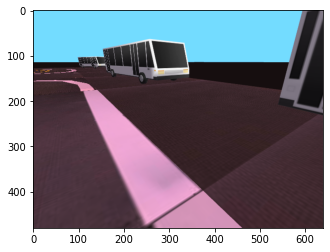

In [34]:
img_example = env.reset()
plt.imshow(img_example)
print(img_example.shape)

In [35]:
from poliduckie_segmentation import Segmentation

segmentation = Segmentation()
prediction = segmentation.predict(cv2.resize(img_example,(320,240),interpolation=cv2.INTER_CUBIC))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

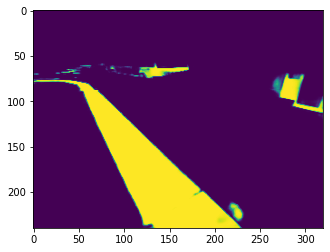

In [36]:
prediction_reshaped = np.reshape(prediction, (240, 320))
plt.imshow(prediction_reshaped)

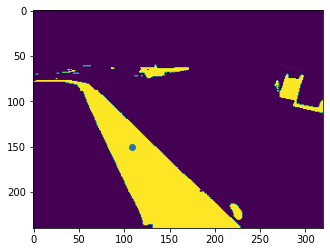

In [37]:
prediction_rounded = np.around(prediction_reshaped)

y = 150
x = np.argwhere(prediction_rounded[y]).mean()

plt.scatter(x,y)
plt.imshow(prediction_rounded)

In [38]:
lane_width = 0.445 # m
x_factor = lane_width/(prediction_rounded.shape[1]*2) # m/px
x_factor

0.0006953125

In [39]:
x_cm = x*x_factor
y_cm = 0.1 # m, needs to be tuned

In [40]:
def get_reference_from_segmentation(img, x_factor=0.00139, y_cm=0.1, N=10):
  y = 150
  x = np.argwhere(prediction_rounded[y]).mean()
  x_cm = x*x_factor
  return np.array([[x_cm, y_cm]]*N).T

In [41]:
from poliduckie_segmentation.control import MPC
M = MPC()

In [48]:
# State X = [x, y, angle, longitudinal speed, angular speed]
X = [0,0,0,0,0]

r = get_reference_from_segmentation(prediction_rounded, N=11)

np.around(M.mpc(X, r, tr=0, Q2=0).toarray().reshape(-1), 2)

array([1., 1.])